In [1]:
#hide
%matplotlib inline
import datetime

import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from sunode.wrappers.as_theano import solve_ivp
import sunode
import sympy as sym

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [183]:
import load_covid_data

## Data

In [267]:
df_sign = load_covid_data.load_data(filter_n_days_100=10)
df_sign = df_sign[df_sign.state.isna()]

countries = pd.Series(df_sign.country.unique())
countries = countries.loc[~countries.isin(['Cruise Ship (total)', 'Cruise Ship'])]
n_countries = len(countries)
countries = countries.rename('country').to_frame().set_index('country')

In [268]:
df_sign = df_sign.reset_index()
df_sign.index.name = 'observation'

previous = (
    df_sign
    .reset_index()
    .groupby(['country'])
    .apply(
        lambda x:
        x.set_index('date')
        .assign(date=x.date.values)
        .sort_index()
        .shift()
    )
)

df_sign = (
    df_sign
    .reset_index()
    .set_index(['country', 'date'])
    .assign(
        previous_date=previous.date,
        previous_confirmed=previous.confirmed,
    )
    .reset_index()
    .set_index('observation')
)

df_sign['new_confirmed'] = df_sign.eval('confirmed - previous_confirmed')
df_sign['days_since_last_data'] = (df_sign['date'] - df_sign['previous_date']).dt.days
df_sign = df_sign.dropna(subset=['new_confirmed'])

## Growth Rate Predictions

In [269]:
pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations = pd.read_csv(pop_file)
populations = populations.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()

idxs = populations.index.get_indexer([c.replace('(total)', '').strip() for c in countries.index])
countries['population'] = [populations.iloc[i].Value if idx != -1 else pd.NA for i, idx in enumerate(idxs)]

In [270]:
countries.loc['Egypt', 'population'] = populations.loc['Egypt, Arab Rep.'].Value
countries.loc['Iran', 'population'] = populations.loc['Iran, Islamic Rep.'].Value
countries.loc['Korea, South', 'population'] = populations.loc['Korea, Rep.'].Value
countries.loc['Hong Kong', 'population'] = populations.loc['Hong Kong SAR, China'].Value
countries.loc['Czechia', 'population'] = populations.loc['Czech Republic'].Value
countries.loc['US (total)', 'population'] = populations.loc['United States'].Value

In [271]:
countries['population'] = countries.population.values.astype('d')

In [326]:
multi_country = True

if multi_country:
    n_countries = 5
    countries = countries.iloc[:n_countries]
    df_sign = df_sign[df_sign.country.isin(countries.index)]
else:
    n_countries = 1
    country = 'Italy'

    countries = countries.loc[country: country]
    df_sign = df_sign[df_sign.country == country]    

In [327]:
start_day = df_sign.date.min() - datetime.timedelta(days=1)
end_data_day = df_sign.date.max()
end_day = end_data_day + datetime.timedelta(days=30)

data_time = pd.date_range(start_day, end_data_day)
time = pd.date_range(start_day, end_day)
country = countries.index

In [328]:
log_scale = False

if not log_scale:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        infections = exp(y.log_infection_rate) * y.S * y.I
        remissions = p.remission_rate * y.I

        change = [
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(infections))
        ]

        return {
            'S': -infections,
            'I': infections - remissions,
            'R': remissions,
            'log_infection_rate': change,
        }
else:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        infections = exp(y.log_infection_rate + y.I + y.S)
        remissions = p.remission_rate * exp(y.I)

        change = [
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(infections))
        ]

        return {
            'S': -infections / exp(y.S),
            'I': (infections - remissions) / exp(y.I),
            'R': remissions / exp(y.R),
            'log_infection_rate': change,
        }


with pm.Model() as model:
    log_pop = np.log(countries['population'].values)
    if multi_country:
        sd = pm.HalfNormal('init_logI_sd')
        mu = pm.Normal('init_logI_mu')
        raw = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = mu + sd * raw - log_pop
        pm.Deterministic('init_logI', init_logI)
    else:
        init_logI = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = init_logI - log_pop
        pm.Deterministic('init_logI', init_logI)

    if multi_country:
        sd = pm.HalfNormal('log_infect_sd')
        mu = pm.Normal('log_infect_mu')
        raw = pm.Normal('log_infect_raw', shape=n_countries)
        log_infect = mu + sd * raw
        pm.Deterministic('log_infect', log_infect)
    else:
        log_infect = pm.Normal('log_infect', shape=n_countries)

    if multi_country:
        sd = pm.HalfNormal('log_remiss_sd')  # In 1/day/infected
        mu = pm.Normal('log_remiss_mu')
        raw = pm.Normal('log_remiss_raw', shape=n_countries)
        log_remiss = mu + sd * raw
        pm.Deterministic('log_remiss', log_remiss)
    else:
        log_remiss = pm.Normal('log_remiss', shape=n_countries)
        
    sd = pm.HalfNormal('infection_change_polys_sd')
    raw = pm.StudentT('infection_change_polys_raw', shape=(n_countries, 8), nu=5)
    infection_change_polys = sd * raw / 100

    if not log_scale:
        init = {
            'S': (1 - tt.exp(init_logI), (n_countries,)),
            'I': (tt.exp(init_logI), (n_countries,)),
            'R': np.zeros(n_countries),
            'log_infection_rate': (log_infect, (n_countries,)),
        }
    else:
        init = {
            'S': (tt.log1p(-tt.exp(init_logI)), (n_countries,)),
            'I': (init_logI, (n_countries,)),
            'R': np.full(n_countries, -20, dtype='d'),
            'log_infection_rate': (log_infect, (n_countries,)),
        }
    
    params = {
        #'infection_rate': (tt.exp(log_infect), (n_countries,)),
        'remission_rate': (tt.exp(log_remiss), (n_countries,)),
        'infection_change_polys': (infection_change_polys, (n_countries, 8)),
        '_placeholder': np.zeros(1),
    }
    
    solution, flat_solution, problem, solver, *_ = solve_ivp(
        t0=0,
        y0=init,
        params=params,
        tvals=np.arange(len(data_time)),
        rhs=sir_rhs,
        solver_kwargs={
            'solver': 'ADAMS',
            'constraints': np.r_[np.ones(n_countries * 3), np.zeros(n_countries)],
        }
    )

    for name in init:
        if log_scale:
            pm.Deterministic(f'solution_{name}', tt.exp(solution[name]))
        else:
            pm.Deterministic(f'solution_{name}', solution[name])

    # The number of people who have at some time been infected
    if log_scale:
        log_cases = tt.log1p(-tt.exp(solution['S'])) + np.log(countries.population.values[None, :])
    else:
        cases = (1 - solution['S']) * countries.population.values[None, :]
    #cases = solution['I'] * countries.population.values[None, :]

    idx_country = countries.index.get_indexer(df_sign.country)
    idx_data_time = data_time.get_indexer(df_sign.date)
    idx_previous_time = data_time.get_indexer(df_sign.previous_date)
    
    assert -1 not in idx_country
    assert -1 not in idx_data_time
    assert -1 not in idx_previous_time
    
    if log_scale:
        log_current_infected = log_cases[idx_data_time, idx_country]
        log_previous_infected = log_cases[idx_previous_time, idx_country]
        #mu = tt.exp(log_current_infected) - tt.exp(log_previous_infected) + 1
        mu_confirmed = tt.exp(log_current_infected)
    else:
        current_infected = cases[idx_data_time, idx_country]
        previous_infected = cases[idx_previous_time, idx_country]
        #mu = current_infected - previous_infected + 1
        mu_confirmed = current_infected
    
    alpha = pm.HalfNormal('confirmed_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_confirmed', mu_confirmed)
    pm.NegativeBinomial(
        'confirmed_count',
        mu_confirmed,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['confirmed'].values)
    )
    
    
    
    if log_scale:
        log_cases = solution['R'] + np.log(countries.population.values[None, :])
    else:
        cases = solution['R'] * countries.population.values[None, :]
    
    if log_scale:
        log_current_recovered = log_cases[idx_data_time, idx_country]
        log_previous_recovered = log_cases[idx_previous_time, idx_country]
        #mu = tt.exp(log_current_infected) - tt.exp(log_previous_infected) + 1
        mu_recovered = tt.exp(log_current_recovered)
    else:
        current_recovered = cases[idx_data_time, idx_country]
        previous_recovered = cases[idx_previous_time, idx_country]
        #mu = current_infected - previous_infected + 1
        mu_recovered = current_recovered
    
    alpha = pm.HalfNormal('recovered_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_recovered', mu_recovered)
    pm.NegativeBinomial(
        'recovered_count',
        mu_recovered,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['recovered'].values + df_sign['deaths'].values)
    )

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [329]:
lib = sunode._cvodes.lib

In [330]:
jac_prod = problem.make_sundials_jac_prod()
lin_solver = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
lib.SUNLinSolInitialize_SPGMR(lin_solver)

lib.CVodeSetLinearSolver(solver._ode, lin_solver, sunode.basic.ffi.NULL)

lib.CVodeSetJacTimes(solver._ode, sunode.basic.ffi.NULL, jac_prod.cffi)

jac_prod = problem.make_sundials_adjoint_jac_prod()
lin_solverB = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
lib.SUNLinSolInitialize_SPGMR(lin_solverB)

lib.CVodeSetLinearSolverB(solver._ode, solver._odeB, lin_solverB, sunode.basic.ffi.NULL)

lib.CVodeSetJacTimesB(solver._ode, solver._odeB, sunode.basic.ffi.NULL, jac_prod.cffi)

0

In [331]:
lib.CVodeSStolerances(solver._ode, 1e-7, 1e-7)
lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
lib.CVodeSetMaxNumSteps(solver._ode, 500)
lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 500)
#lib.CVodeSetMinStep(solver._ode, 1e-12)
#lib.CVodeSetMinStepB(solver._ode, solver._odeB, 1e-12)
lib.CVodeSetMaxOrd(solver._ode, 4)
lib.CVodeSetMaxOrdB(solver._ode, solver._odeB, 4)
#lib.CVodeSetInitStep(solver._ode, 1e-7)
#lib.CVodeSetInitStepB(solver._ode, solver._odeB, -1e-6)
#lib.CVodeSetMaxStep(solver._ode, 50)
#lib.CVodeSetMaxStepB(solver._ode, solver._odeB, 50)

0

In [332]:
func = model.logp_dlogp_function()
func.set_extra_values({})

In [333]:
np.random.seed(42)

In [334]:
x0 = np.random.randn(func.size)
func(x0)

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


(array(-65108.18372342),
 array([-1.23399623e+04,  3.64524921e+04, -5.53444759e+01,  2.79817947e+02,
         5.91234255e+04, -1.31902448e+02,  6.83338402e+02, -3.48577132e+04,
         3.24805294e+04, -8.48404019e+02,  2.41901030e+02,  7.25343145e+04,
        -1.97070976e+03,  1.45721106e+01,  5.41230655e+03, -3.38504910e+04,
         1.31370399e+01, -2.13464878e+01, -6.08744582e+03,  6.88312078e+01,
        -3.46374193e+00,  5.04368785e+02, -3.29106830e-01, -3.14860327e+00,
        -6.25676331e+00, -1.49286626e+00,  1.07423964e+00, -4.38485352e-01,
         6.72260543e-01,  3.44175646e-01,  7.28941853e-01, -4.17998268e-01,
         1.33251957e+00,  1.27563386e+00, -8.66080458e-01,  1.12860282e+00,
        -2.48468442e-01,  1.33004665e+00,  2.09348331e+01,  3.51225309e+02,
         5.85761118e+02,  1.45860233e+02,  7.15076760e+00,  5.72091290e-01,
         1.23847105e+00,  7.82708418e-01, -1.58741663e-01, -1.52407196e+01,
        -2.89911476e+01, -8.51188285e+00, -1.03904217e+00,  4.3

In [335]:
out = sunode._cvodes.ffi.new('long[1]')
lib.CVodeGetNumNonlinSolvIters(solver._ode, out)
out[0]

287

In [336]:
%timeit func(x0)

7.16 ms ± 20.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [337]:
import theano
func_dets = theano.function(model.free_RVs, model.deterministics)
dets = {var.name: vals for var, vals in zip(model.deterministics, func_dets(**func.array_to_dict(x0)))}

In [338]:
import theano
func_logps = theano.function(model.free_RVs, [var.logp_elemwiset for var in model.observed_RVs])
logps = {var.name: vals for var, vals in zip(model.observed_RVs, func_logps(**func.array_to_dict(x0)))}

In [339]:
(~np.isfinite(logps['recovered_count'])).nonzero()

(array([], dtype=int64),)

In [341]:
dets['solution_R'].min()

0.0

In [ ]:
with model:
    trace = pm.sample(tune=1000, chains=4, cores=4, discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [recovered_alpha, confirmed_alpha, infection_change_polys_raw, infection_change_polys_sd, log_remiss_raw, log_remiss_mu, log_remiss_sd, log_infect_raw, log_infect_mu, log_infect_sd, init_logI_raw, init_logI_mu, init_logI_sd]


In [139]:
import arviz
tr = arviz.from_pymc3(
    trace=trace,
    coords={
        'data_time': data_time,
        'country': country,
        'time': time,
        'observation': df_sign.index,
        'infection_poly': np.arange(8),
    },
    dims={
        'init_logI_raw': ['country'],
        'init_logI': ['country'],
        'log_infect_raw': ['country'],
        'log_infect': ['country'],
        'log_remiss_raw': ['country'],
        'log_remiss': ['country'],
        'solution_I': ['data_time', 'country'],
        'solution_S': ['data_time', 'country'],
        'solution_R': ['data_time', 'country'],
        'solution_log_infection_rate': ['data_time', 'country'],
        'infection_change_polys_raw': ['country', 'infection_poly'],
        'infection_change_polys': ['country', 'infection_poly'],
        'confirmed_sigma': ['country'],
        'recovered_sigma': ['country'],
        'mu_confirmed': ['observation'],
        'mu_recovered': ['observation'],
    },
    log_likelihood=False,
).posterior

In [140]:
import xarray as xr

In [141]:
xr.DataArray(countries['population'])

<xarray.DataArray 'population' (country: 5)>
array([34656032.,  2876101., 40606052.,    55599.,    77281.])
Coordinates:
  * country  (country) object 'Thailand' 'Japan' ... 'Malaysia' 'Germany'

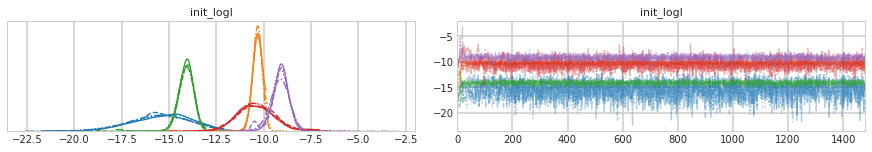

In [142]:
arviz.plot_trace(tr, var_names=['init_logI'], compact=True);

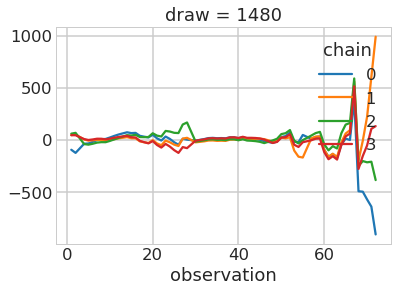

In [143]:
(tr.mu - xr.DataArray(df_sign.cases, dims=('observation',))).isel(draw=-1).plot.line(x='observation')

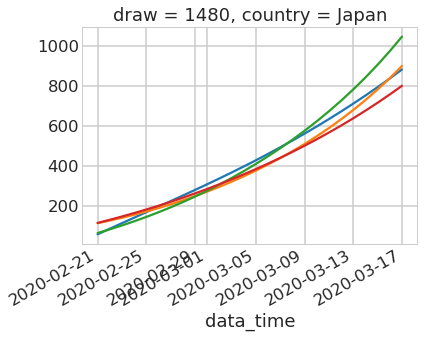

In [144]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=1, draw=-1).plot.line(x='data_time', add_legend=False);

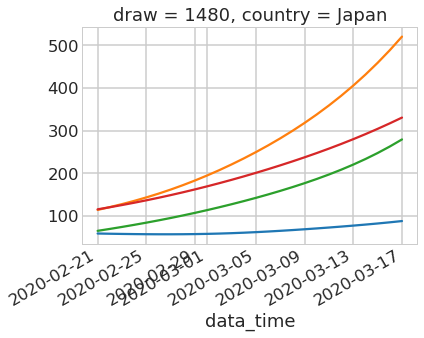

In [148]:
((tr.solution_I) * xr.DataArray(countries['population'])).isel(country=1, draw=-1).plot.line(x='data_time', add_legend=False);

In [164]:
tr

<xarray.Dataset>
Dimensions:                            (chain: 4, country: 5, data_time: 26, draw: 1481, infection_poly: 8, observation: 68, observed_infected_alpha_dim_0: 5, solution_log_infection_rate_dim_0: 26, solution_log_infection_rate_dim_1: 5)
Coordinates:
  * chain                              (chain) int64 0 1 2 3
  * draw                               (draw) int64 0 1 2 3 ... 1478 1479 1480
  * country                            (country) object 'Thailand' ... 'Germany'
  * infection_poly                     (infection_poly) int64 0 1 2 3 4 5 6 7
  * data_time                          (data_time) datetime64[ns] 2020-02-21 ... 2020-03-17
  * solution_log_infection_rate_dim_0  (solution_log_infection_rate_dim_0) int64 0 ... 25
  * solution_log_infection_rate_dim_1  (solution_log_infection_rate_dim_1) int64 0 ... 4
  * observed_infected_alpha_dim_0      (observed_infected_alpha_dim_0) int64 0 ... 4
  * observation                        (observation) int64 1 2 4 5 ... 70 71 72
Data variables:
    init_logI_mu                       (chain, draw) float64 0.02552 ... 2.312
    init_logI_raw                      (chain, draw, country) float64 -0.8949 ... -0.1649
    log_infect_mu                      (chain, draw) float64 0.9276 ... -1.272
    log_infect_raw                     (chain, draw, country) float64 -0.7451 ... 0.5433
    log_remiss_mu                      (chain, draw) float64 0.00713 ... -3.073
    log_remiss_raw                     (chain, draw, country) float64 -0.5178 ... 0.3852
    infection_change_polys_raw         (chain, draw, country, infection_poly) float64 -0.7332 ... 0.602
    init_logI_sd                       (chain, draw) float64 0.3384 ... 1.796
    init_logI                          (chain, draw, country) float64 -17.64 ... -9.24
    log_infect_sd                      (chain, draw) float64 1.543 ... 0.4484
    log_infect                         (chain, draw, country) float64 -0.222 ... -1.028
    log_remiss_sd                      (chain, draw) float64 0.4512 ... 1.416
    log_remiss                         (chain, draw, country) float64 -0.2265 ... -2.528
    infection_change_polys_sd          (chain, draw) float64 1.406 ... 0.5944
    solution_S                         (chain, draw, data_time, country) float64 1.0 ... 0.8785
    solution_I                         (chain, draw, data_time, country) float64 2.187e-08 ... 0.0927
    solution_R                         (chain, draw, data_time, country) float64 0.0 ... 0.02881
    solution_log_infection_rate        (chain, draw, solution_log_infection_rate_dim_0, solution_log_infection_rate_dim_1) float64 -0.222 ... -1.046
    observed_infected_alpha            (chain, draw, observed_infected_alpha_dim_0) float64 5.407 ... 18.72
    mu                                 (chain, draw, observation) float64 13.54 ... 9.39e+03
Attributes:
    created_at:                 2020-03-18T22:02:00.846390
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.7

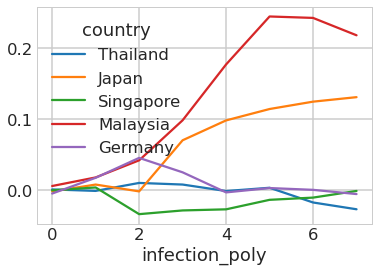

In [180]:
(
    (tr.infection_change_polys_sd * tr.infection_change_polys_raw)
    .cumsum('infection_poly')
    .median(['draw', 'chain'])
    .plot
    .line(x='infection_poly')
);

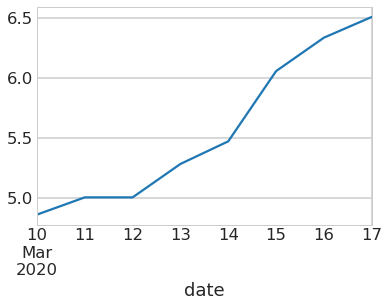

In [182]:
np.log(df_sign[df_sign.country == 'Malaysia'].set_index('date').cases).plot()

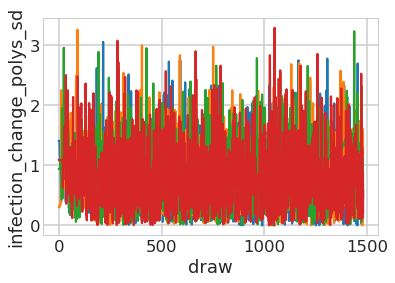

In [170]:
tr.infection_change_polys_sd.plot.line(x='draw', add_legend=False);

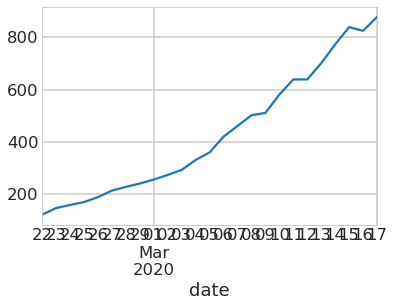

In [49]:
df_sign.query("country == 'Japan'").set_index('date').cases.plot()

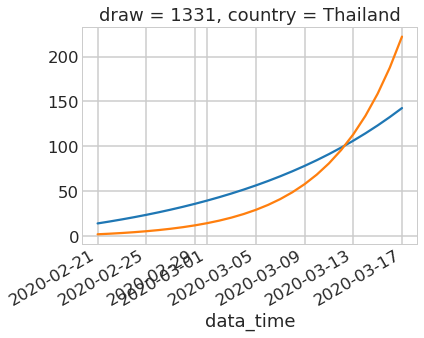

In [50]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=0, draw=-1).plot.line(x='data_time', add_legend=False);

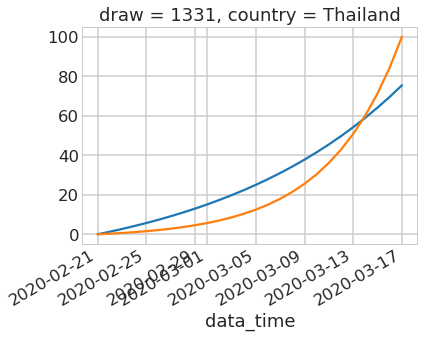

In [51]:
(tr.solution_R * xr.DataArray(countries['population'])).isel(country=0, draw=-1).plot.line(x='data_time', add_legend=False);

In [44]:
tr.solution_S.diff('data_time').max()

<xarray.DataArray 'solution_S' ()>
array(-2.27672892e-09)

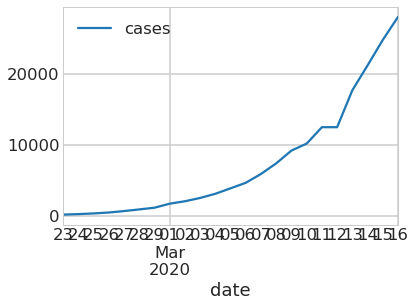

In [74]:
df_sign.plot.line(x='date', y='cases')